## Import Required Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Type, List
import torch.optim as optim

## Define the ResNet Block without batch normalization

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

## Define the ResNet model  without batch normalization

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, img_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18_no_bn(num_classes=10, img_channels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, img_channels)

## Preprocess the Datasets

In [4]:
transform_svhn = Compose([
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052])
])

transform_mnist = Compose([
    Resize((32, 32)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])


## Load Datasets

In [5]:
train_dataset_svhn = datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
train_loader_svhn = DataLoader(train_dataset_svhn, batch_size=16, shuffle=True)

test_dataset_svhn = datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
test_loader_svhn = DataLoader(test_dataset_svhn, batch_size=16, shuffle=False)

test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=16, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## Initialization

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18_no_bn().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

## Training definition - loop

In [7]:
num_epochs = 10
losses = []

for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_svhn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100.*correct/total:.2f}%')

Training Epochs:  10%|█         | 1/10 [01:06<09:56, 66.32s/it]

Epoch 1/10, Training Loss: 1.5663, Training Accuracy: 45.41%


Training Epochs:  20%|██        | 2/10 [02:07<08:27, 63.39s/it]

Epoch 2/10, Training Loss: 0.5110, Training Accuracy: 84.87%


Training Epochs:  30%|███       | 3/10 [03:08<07:15, 62.28s/it]

Epoch 3/10, Training Loss: 0.3865, Training Accuracy: 88.66%


Training Epochs:  40%|████      | 4/10 [04:09<06:09, 61.63s/it]

Epoch 4/10, Training Loss: 0.3241, Training Accuracy: 90.62%


Training Epochs:  50%|█████     | 5/10 [05:09<05:06, 61.31s/it]

Epoch 5/10, Training Loss: 0.2820, Training Accuracy: 91.93%


Training Epochs:  60%|██████    | 6/10 [06:10<04:04, 61.13s/it]

Epoch 6/10, Training Loss: 0.2472, Training Accuracy: 92.78%


Training Epochs:  70%|███████   | 7/10 [07:11<03:03, 61.06s/it]

Epoch 7/10, Training Loss: 0.2202, Training Accuracy: 93.67%


Training Epochs:  80%|████████  | 8/10 [08:12<02:02, 61.02s/it]

Epoch 8/10, Training Loss: 0.1907, Training Accuracy: 94.51%


Training Epochs:  90%|█████████ | 9/10 [09:13<01:00, 60.96s/it]

Epoch 9/10, Training Loss: 0.1716, Training Accuracy: 95.06%


Training Epochs: 100%|██████████| 10/10 [10:14<00:00, 61.40s/it]

Epoch 10/10, Training Loss: 0.1463, Training Accuracy: 95.75%


## Plotting the training loss

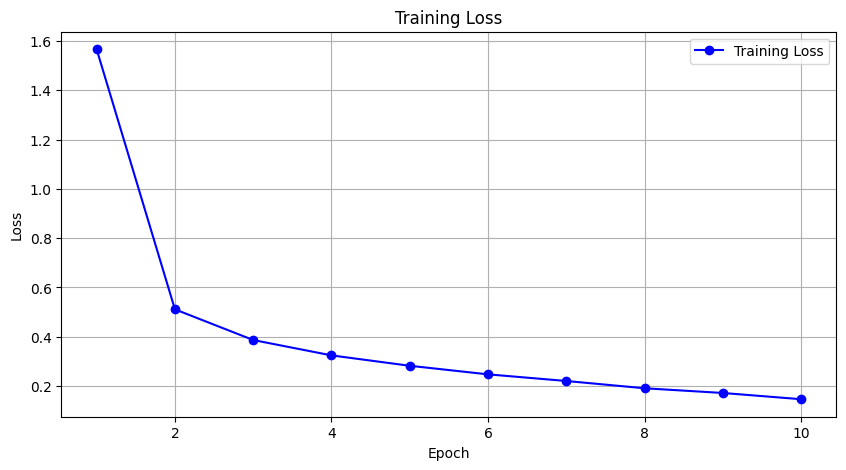

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

## Testing the Model

In [13]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

## Test on SVHN

In [14]:
accuracy_svhn = test_model(model, test_loader_svhn)

Accuracy: 90.74%


## Test on MNIST

In [15]:
accuract_Mnist = test_model(model, test_loader_mnist)

Accuracy: 62.69%
